In [1]:
!pip install requests
!pip install newsapi-python
!pip install finnhub-python
!pip install scikit-learn
import finnhub
import time
import yfinance as yf
import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from newsapi import NewsApiClient
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
# This code block is for functions that help with testing / printing outputs

# uses finnhub api
# Example of req:
# finnhub_client.company_news('SPY', _from="2023-09-04", to="2024-09-04")
def print_headlines_datetimes(req):
  for article in req:
    print(datetime.utcfromtimestamp(article['datetime']).strftime('%Y-%m-%d'))

# How to make df:
# stock = yf.Ticker("SPY")
# hist = stock.history(period="1y")
# df = pd.DataFrame(hist)
def print_SPY_performance_datetimes(df):
  for ts, row in df.iterrows():
    print(ts.strftime('%Y-%m-%d'))

def one_year_ago():
  return (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

def date_now():
  return datetime.now().strftime('%Y-%m-%d')

# unix_time_stamp -> YYYY-MM-DD
def unix_timestamp_to_date(unix_timestamp):
  return datetime.utcfromtimestamp(unix_timestamp).strftime('%Y-%m-%d ')



In [3]:
# Funcs for model creation and data aggregation

def write_headlines(tkr, from_date, to_date, finnhub_api_key):
    try:
      finnhub_client = finnhub.Client(api_key=finnhub_api_key)
      df = pd.DataFrame()
      news = finnhub_client.company_news(tkr, _from=from_date, to=to_date)
      for article in news:
        date = unix_timestamp_to_date(article['datetime'])
        new_row = pd.DataFrame({
        'date': [date],
        'headline': [article['headline']]
        })
        df = pd.concat([df, new_row], ignore_index=True)
      return df
    except:
      return 'err'

def write_performance_dict(tkr):
  try:
    perf_dict = {}
    stock = yf.Ticker(tkr)
    hist = stock.history(period="1y")
    yf_df = pd.DataFrame(hist)
    for ts, row in yf_df.iterrows():
      info = row.to_dict()
      perc_change = (info['Close'] - info['Open']) / info['Open']
      perf_dict[ts.strftime('%Y-%m-%d')] = perc_change
    return perf_dict
  except:
    return "err"

def add_data(perf_dict, headlines_df):
  try:
    df = pd.DataFrame()
    # main_dict = {}
    for i, row in headlines_df.iterrows():
      date = row['date'].strip()
      headline = row['headline']
      pc = perf_dict.get(date, 'Undefined key')
      if(type(pc) == float):
        new_row = pd.DataFrame({
        'headline': [headline],
        'percent_change': [pc]
        })
        # main_dict[headline] = pc
        df = pd.concat([df, new_row], ignore_index=True)
    return df
  except:
    return pd.DataFrame()

def make_model(df, vectorizer):
  # FROM DOCS
  X = vectorizer.fit_transform(df['headline'])

  y = df['percent_change'].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)

  return [model, vectorizer, mse]

def prepare_df(stocks, finnhub_key):
  df = pd.DataFrame()
  for stock in stocks:
    perf_dict = write_performance_dict(tkr=stock)
    headlines_df = write_headlines(tkr=stock, from_date=one_year_ago(), to_date=date_now(), finnhub_api_key=finnhub_key)
    if (type(perf_dict) != str and type(headlines_df) != str):
      df = pd.concat([df, add_data(perf_dict, headlines_df)], ignore_index=True)
  return df

def train_models(df):
  tfidfVectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
  countVectorizer = CountVectorizer()
  hashingVectorizer = HashingVectorizer(stop_words='english', n_features=10)

  models = []
  for vectorizer in [tfidfVectorizer, countVectorizer, hashingVectorizer]:
    model = make_model(df, vectorizer)
    models.append(model)
  return models

In [4]:
# funcs for front end

def get_stock_input():
  default_stocks_list=['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA']
  print('Would you like to train the model using your own stock list? (y/n) '+'\n'+'(Note: Acceptable size of stock list is dependent on API key)')
  inp = input()
  match inp:
    case 'y':
      print('Please input stocks tickers separated by spaces')
      stocks = list(input().split())
      return stocks
      print('Creating model using custom stock list...')
    case 'n':
      print('Creating model using default stock list...')
      return default_stocks_list
    case default:
      print('Invalid input')
      get_stock_input()

def predict_headline(model, vectorizer):
  print('Input headline to test\n')
  headline = input()
  headline_vector = vectorizer.transform([headline])
  pc = model.predict(headline_vector)
  if pc[0] > 0:
    print('Market Sentiment: Bullish (Estimated percent change: + %' + str(pc[0]*100)+')\n')
  else:
    print('Market Sentiment: Bearish (Estimated percent change: - %' + str(pc[0]*100)[1:]+')\n')

def plot_feature_importance(model, vectorizer, top_n=30):
    if hasattr(vectorizer, "get_feature_names_out"): # tfidf and count case
         feature_names = np.array(vectorizer.get_feature_names_out())
    else: # Hash case
        feature_names = np.array([f"Feature {i}" for i in range(model.feature_importances_.shape[0])])

    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]  # Get top N features

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[indices], importances[indices], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Top Important Features in Model")
    plt.show()

def plot_models(models):
  for model, vectorizer, mse in models:
      print(f"Model: {vectorizer.__class__.__name__} | MSE: {mse:.4f}")
      plot_feature_importance(model, vectorizer)

Please input a finnhub API key: 
(You can get one for free at https://finnhub.io/)
cr140apr01qo0i56tudgcr140apr01qo0i56tue0
Would you like to train the model using your own stock list? (y/n) 
(Note: Acceptable size of stock list is dependent on API key)
y
Please input stocks tickers separated by spaces
AAPL AMZN GOOGL TSLA
Models created! Visualizing vectorizers:
Model: TfidfVectorizer | MSE: 0.0005


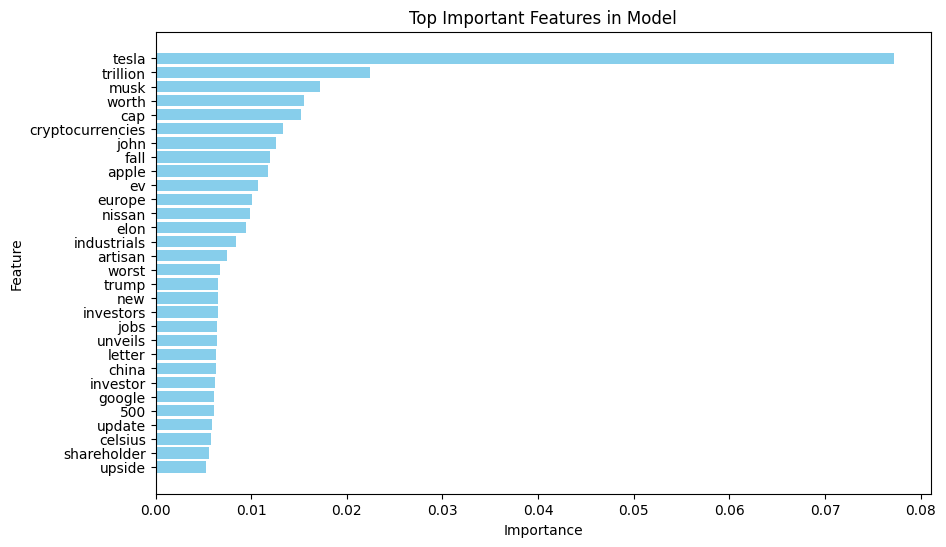

Model: CountVectorizer | MSE: 0.0005


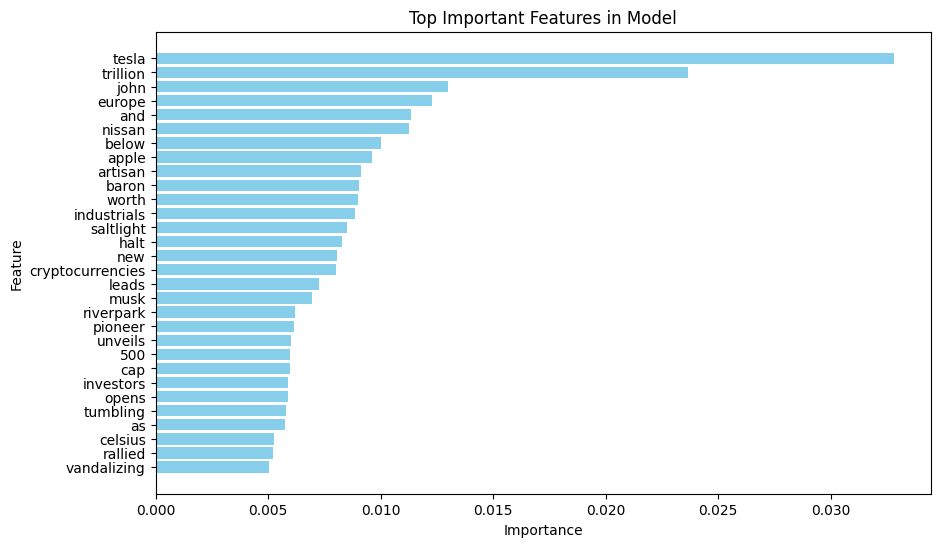

Model: HashingVectorizer | MSE: 0.0005


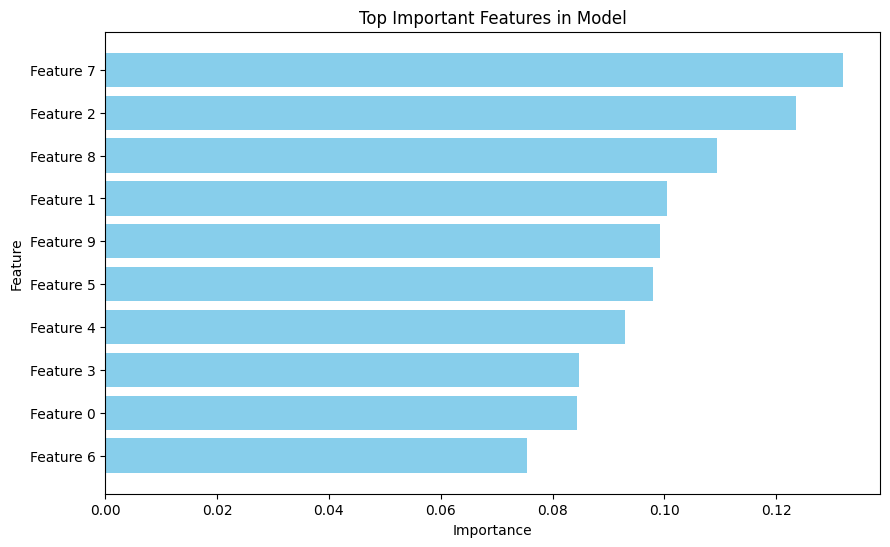

What would you like to do (input 1, 2, or 3)? 
1 Predict Headlines 
2 Retrain models on different stocklist
3 Quit


KeyboardInterrupt: Interrupted by user

In [5]:
# "FRONT END"
# Please make sure to run preceeding code blocks this code block
# ""

print('Please input a finnhub API key: \n(You can get one for free at https://finnhub.io/)')
finnhub_key = input()

def print_stuff():
  stocks = get_stock_input()
  df = prepare_df(stocks, finnhub_key)
  models = train_models(df)
  print('Models created! Visualizing vectorizers:')
  plot_models(models)
  return models

def control_flow(models):

  print('What would you like to do (input 1, 2, or 3)? \n1 Predict Headlines \n2 Retrain models on different stocklist\n3 Quit')
  inp = input()
  match inp:
    case '1':
      print("Which vectorizer would you like to use (input 1, 2, or 3)? \n1 tfidf\n2 count \n3 hash")
      inp = input()
      match inp:
        case '1':
          predict_headline(models[0][0], models[0][1])
          control_flow(models)
        case '2':
          predict_headline(models[1][0], models[1][1])
          control_flow(models)
        case '3':
          predict_headline(models[2][0], models[2][1])
          control_flow(models)
        case default:
          print('Invalid input')
          control_flow(models)
    case '2':
      models2 = print_stuff()
      control_flow(models2)
    case '3':
      exit()
    case default:
      print('Invalid input')
      control_flow(models)
models = print_stuff()
control_flow(models)
